# Example of catalog generation and usage
## using history files and getting info from CESM CASEROOT

In [1]:
import ast
import os
import os.path
import pprint
import warnings

from dask_jobqueue import PBSCluster
from distributed import Client
from distributed.worker import get_client
import intake

from esm_catalog_utils import query_from_caseroot, caseroot_to_esm_datastore

In [2]:
%load_ext autoreload
%autoreload 2

# Specification of Input

In [3]:
caseroot = "/glade/work/klindsay/cesm20_cases/B1850/b.e21.B1850.f19_g17.ex_output.001"

# Obtain Computational Resources

In [4]:
user = os.getenv('USER')
logdir = f'/glade/scratch/{user}/dask_tmp'
with warnings.catch_warnings():
    warnings.filterwarnings(action="ignore", message=".*already in use", module=".*node")
    cluster = PBSCluster(
        cores = 1,
        memory = '4GiB',
        processes = 1,
        local_directory = logdir,
        log_directory = logdir,
        resource_spec = 'select=1:ncpus=1:mem=4GB',
        queue = 'casper',
        account = 'P93300070',
        walltime = '0:30:00',
        interface = 'ib0',
    )

cluster.scale(12)

client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/klindsay/esm_catalog_utils/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/klindsay/esm_catalog_utils/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.45:38647,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/klindsay/esm_catalog_utils/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


# Generate and save catalog

In [5]:
%%time
print("creating esm_datastore")
esm_datastore = caseroot_to_esm_datastore(caseroot, use_dask=True)
print(esm_datastore)

creating esm_datastore
generating esm_datastore for b.e21.B1850.f19_g17.ex_output.001
<sample catalog with 13 dataset(s) from 264 asset(s)>
CPU times: user 532 ms, sys: 201 ms, total: 733 ms
Wall time: 7.72 s


In [6]:
df = esm_datastore.df
vals = df.frequency.unique() 
print(vals)

['month_1' 'day_1' 'year_1' 'unknown' 'once']


In [7]:
case = query_from_caseroot(caseroot, "CASE")
datastore_directory = os.path.join(os.getcwd(), "generated")
os.makedirs(datastore_directory, exist_ok=True)
esm_datastore.serialize(name=case, directory=datastore_directory, catalog_type="file")

Successfully wrote ESM catalog json file to: file:///glade/work/klindsay/analysis/esm_catalog_utils/notebooks/generated/b.e21.B1850.f19_g17.ex_output.001.json


# Generate catalog, in update mode

In [8]:
%%time
path = os.path.join(datastore_directory, f"{case}.json")
print("updating esm_datastore")
esm_datastore = intake.open_esm_datastore(path)
print(esm_datastore)
esm_datastore = caseroot_to_esm_datastore(
    caseroot, esm_datastore_in=esm_datastore, use_dask=True
)
print(esm_datastore)

updating esm_datastore
<b.e21.B1850.f19_g17.ex_output.001 catalog with 13 dataset(s) from 264 asset(s)>
appending esm_datastore for b.e21.B1850.f19_g17.ex_output.001
<b.e21.B1850.f19_g17.ex_output.001 catalog with 13 dataset(s) from 264 asset(s)>
CPU times: user 205 ms, sys: 20.1 ms, total: 225 ms
Wall time: 4.48 s


# Load catalog, and perform a computation
## use read_csv_kwargs argument to enable parsing of list output in varname column

In [9]:
esm_datastore = intake.open_esm_datastore(
    path, read_csv_kwargs={"converters": {"varname": ast.literal_eval}}
)
print(esm_datastore)
esm_datastore.df.columns

<b.e21.B1850.f19_g17.ex_output.001 catalog with 13 dataset(s) from 264 asset(s)>


Index(['case', 'scomp', 'component', 'path', 'stream', 'datestring',
       'frequency', 'date_start', 'date_end', 'varname', 'size'],
      dtype='object')

In [10]:
df = esm_datastore.df
vals = df.frequency.unique() 
print(vals)

['month_1' 'day_1' 'year_1' 'unknown' 'once']


In [11]:
varname = 'FG_CO2_2'

In [12]:
subset = esm_datastore.search(frequency='day_1', varname=varname)
print(subset)

<b.e21.B1850.f19_g17.ex_output.001 catalog with 1 dataset(s) from 36 asset(s)>


In [13]:
%%time
with warnings.catch_warnings():
    warnings.filterwarnings(
        action="ignore", message=".*single-machine", module=".*base"
    )
    ds_dict = subset.to_dataset_dict()


--> The keys in the returned dictionary of datasets are constructed as follows:
	'case.scomp.component.stream.frequency'


CPU times: user 1.41 s, sys: 250 ms, total: 1.66 s
Wall time: 3.2 s


In [14]:
key = list(ds_dict)[0]
ds = ds_dict[key]
ds

<xarray.Dataset>
Dimensions:                 (time: 1095, nlat: 384, nlon: 320)
Coordinates: (12/36)
  * time                    (time) object 0001-01-02 00:00:00 ... 0004-01-01 ...
    ULONG                   (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ULAT                    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG                   (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLAT                    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    days_in_norm_year       timedelta64[ns] 365 days
    ...                      ...
    hflux_factor            float64 2.439e-05
    fwflux_factor           float64 0.0001
    salinity_factor         float64 -0.00347
    sflux_factor            float64 0.1
    nsurface_t              float64 8.61e+04
    nsurface_u              float64 8.297e+04
Dimensions without coordinates: nlat, nlon
Data variables:
    FG_CO2_2                (time, nlat, nlon) float32 dask.array<chunksize=(31, 384, 320), meta=np.ndarray>
Attributes: (12/19)
    title:                           b.e21.B1850.f19_g17.ex_output.001
    history:                         none
    Conventions:                     CF-1.0; http://www.cgd.ucar.edu/cms/eato...
    time_period_freq:                day_1
    model_doi_url:                   https://doi.org/10.5065/D67H1H0V
    contents:                        Diagnostic and Prognostic Variables
    ...                              ...
    intake_esm_attrs:component:      ocn
    intake_esm_attrs:stream:         h.ecosys.nday1
    intake_esm_attrs:frequency:      day_1
    intake_esm_attrs:varname:        photoC_sp_zint_2,photoC_diat_zint_2,phot...
    intake_esm_attrs:_data_format_:  netcdf
    intake_esm_dataset_key:          b.e21.B1850.f19_g17.ex_output.001.pop.oc...

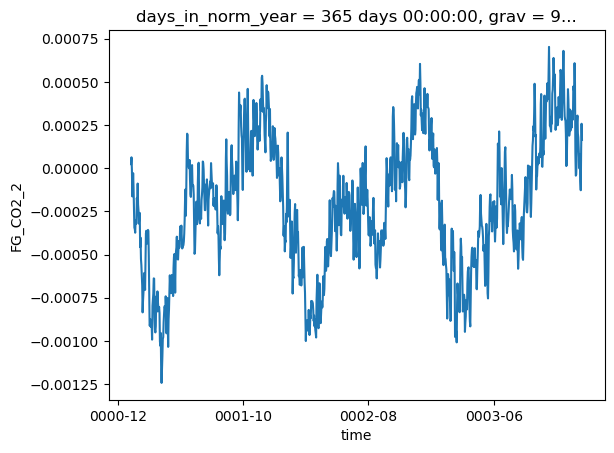

In [15]:
dims = ds[varname].dims[-2:]
ds[varname].isel(time=slice(0,365*3)).mean(dims).plot()

# Release Computational Resources

In [16]:
client.close()
cluster.close()